In [1]:
# imports
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import ode
%matplotlib inline

In [2]:
#Input Parameters

# fixed resistance
R = 1800.0 # Ohm
# capacitances
C1 = 10.0**-8 # F
C2 = 10.0**-7 # F
# inductance
L = 18.0 * 10**-3 # H

# resistances inside the Chua diode
R1 = 220.0 # Ohm
R2 = 220.0 # Ohm
R3 = 2200.0 # Ohm
R4 = 22000.0 # Ohm
R5 = 22000.0 # Ohm
R6 = 3300.0 # Ohm

# Satuation voltage
E_sat = 9.0 # V

In [3]:
#Intermediate variables

G = 1 / R

m01 = 1 / R1
m11 = -1 / R3
BP1 = R3 / (R2 + R3) * E_sat

m02 = 1 / R4
m12 = -1 / R6
BP2 = R6 / (R5 + R6) * E_sat

m0 = m11 + m02
m1 = m11 + m12

qBP2 = m1*BP2
qBP1 = m1*BP2+m0*(BP1-BP2)

m_op = qBP1 / (E_sat - BP1)
m_on = -m_op

In [4]:
def vi_char(v):
    ''' 
    v-i characteristics - piecewise-linear function
    input:  v = voltage across Chua diode
    output: current across Chua diode, response
    '''
    abs_v = abs(v)
    
    if abs_v < BP2:
        # inner segment
        return m1*v 
    elif abs(v) < BP1:
        # outer segments
        if v > 0:
            # positive side
            return qBP2 + m0*(v-BP2)
        else:
            # negative side
            return -qBP2 + m0*(v+BP2)
    else:
        # decaying segments
        if v > 0:
            # positive side
            return qBP1 - m_op*(v-BP1)
        else:
            # negative side
            return -qBP1 + m_on*(v+BP1)

### plot of vi_char

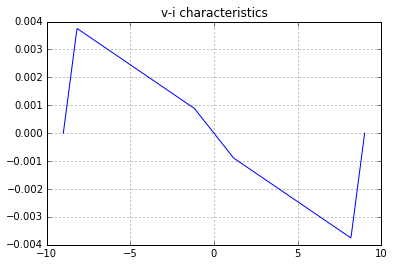

In [5]:
# demonstration plot of v-i characteristics
x = np.linspace(-E_sat, E_sat, 500)
plt.plot(x, map(vi_char, x))
plt.title('v-i characteristics')
plt.grid()

In [6]:
def derivative(t, y, dimmy):
    ''' step function for simulation '''
    v_C1 = (G*(y[1]-y[0]) - vi_char(y[0])) / C1
    v_C2 = (G*(y[0]-y[1]) + y[2]) / C2
    i_L = -y[1] / L
    return [v_C1, v_C2, i_L]

In [9]:


y0, t0 = [-0.5, -0.2, 0.0], 0.0

r = ode(derivative).set_integrator('dopri5')
r.set_initial_value(y0, t0).set_f_params(1)

t_max = 0.05
dt = 0.000001

num_steps = t_max / dt + 2
v_C1 = np.zeros(num_steps)
v_C2 = np.zeros(num_steps)
i_L = np.zeros(num_steps)

v_C1[0], v_C2[0], i_L[0] = y0

f = open('output_%d.csv' % int(time.time()), 'w')
idx = 1
try:
    while r.successful() and r.t < t_max:
        r.integrate(r.t+dt)

        v_C1[idx], v_C2[idx], i_L[idx] = r.y[0:3]
        idx += 1

        f.write('%f,%f,%f' % tuple(r.y) + ',%f' % r.t + '\n')
except Exception as e:
    f.close()
    raise e
f.close()

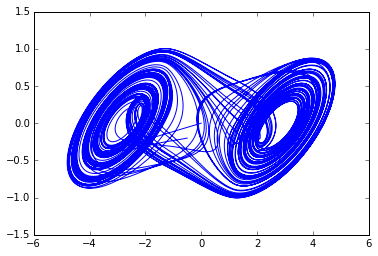

In [10]:
plt.plot(v_C1, v_C2)